In [53]:
import pandas as pd
df = pd.read_excel(r'C:\Users\c.tandui\Desktop\TANDUI\Churn Analysis Project\Telco-Customer-Churn.xlsx')
df.head()

print("--- Data Info ---")
df.info()
print("\n--- Missing Values ---")
print(df.isnull().sum())

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(f"Missing values in TotalCharges after conversion: {df['TotalCharges'].isnull().sum()}")

df['TotalCharges'] = df['TotalCharges'].fillna(0)

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

Data Cleaning and Preparation
1. Data Inspection: The dataset contains 7,043 records.
2. Type Correction: The `TotalCharges` column was Identified as a string object due to white spaces, this has been converted to a numeric float for calculation.
3. Missing Values: Minimal missing values were found in `TotalCharges` and have been handled to ensure model accuracy.

Exploratory Data Analysis (EDA)
- In this section, I explore the relationships between customer attributes and churn.

Unique values in Churn column: [0 1]
0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64


C:\Users\c.tandui\AppData\Local\Temp\ipykernel_24604\4222034950.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='pastel')


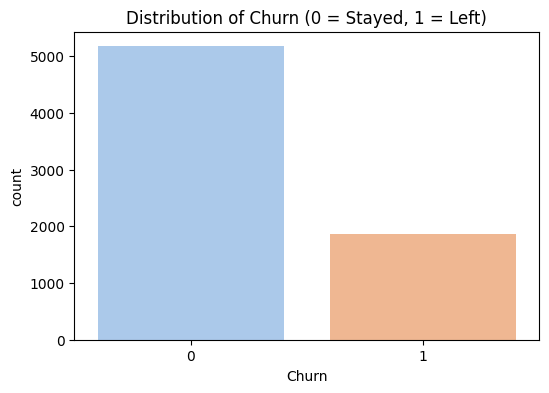

Overall Churn Rate: 26.54%


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

#Convert 'Yes' to 1 and 'No' to 0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print("Unique values in Churn column:", df['Churn'].unique())
print(df['Churn'].head())

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='pastel')
plt.title('Distribution of Churn (0 = Stayed, 1 = Left)')
plt.show()

# Calculate exact percentage
churn_rate = df['Churn'].mean() * 100
print(f"Overall Churn Rate: {churn_rate:.2f}%")


Busness Insight:
- A Churn Rate of 26.54% indicates that the company is losing 1 in every 4 customers. In FMCG world, this can be significantly problematic.

Uncovering the "Why".
- My Goal is to identify who these 26% are and why they're leaving.

1. Contract Type
-Does having a 2-year contact prevent churn?

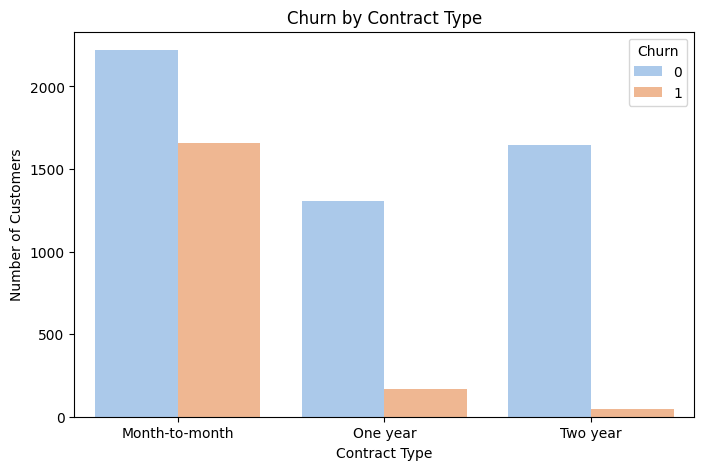

In [55]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df, palette='pastel')
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()

Insight:
- The Month-to-month bar is significantly higher than the One-year and two-year bars.
- This is because the Month-to-month contract account segment possesses a low barrier to exit and high price sensitivity.

2. Tenure
-At what month do customers usually quit?
-Is it month 1? 2?...month 12?

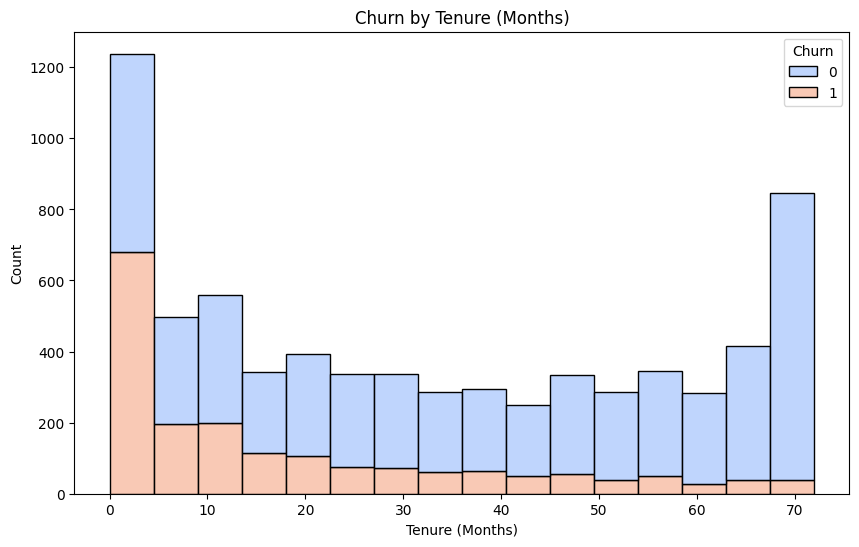

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(x='tenure', hue='Churn', data=df, multiple='stack', palette='coolwarm')
plt.title('Churn by Tenure (Months)')
plt.xlabel('Tenure (Months)')
plt.show()

Insights:
- Evidently it can be said that from Months 0 - 5, the "Churn" bar is significantly tall at the beginning. This indicates that new customers are the most likely to leave.
-On the right side(60+ months), note how short the "Churn" bars are for long-term customers?


Step 4: Feature Engineering

In [57]:
df.drop('customerID', axis=1, inplace=True)
df_model = pd.get_dummies(df, drop_first=True)
print(F"Old shape: {df.shape}")
print(f"New shape: {df_model.shape}")
print("\nHere is what the data looks like now (all number):")
print(df_model.head())

Old shape: (7043, 20)
New shape: (7043, 31)

Here is what the data looks like now (all number):
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                            True  ...         

Building the Brain:
Model Type: Logistic Regression
- Why? - It's industry standard for simple Yes/No predictions.
- Goal - I'll feed it 80% of the data to train, thereafter feed it the remaining 20% of the data to test and see if it can accurately predict who churned.

Training and Evaluation of the Model

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Define X (Features - the study material) and y (Target - the answer key).
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# 2. Split the data: 80% for training, 20% for testing.
# random_state=42 ensures we get the same shuffle every time.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train the model.
# max_iter=1000 gives the model enough time to find the mathematical pattern
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train, y_train)

# 4. Predict on the test set.
predictions = logmodel.predict(X_test)

print("--- Model Accuracy ---")
print(f"Accuracy Score: {accuracy_score(y_test, predictions)*100:.2f}%")
print("\n--- Detailed Report ---")
print(classification_report(y_test, predictions))

--- Model Accuracy ---
Accuracy Score: 82.19%

--- Detailed Report ---
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



Insight:
1. 82% Accuracy -The model successfully predicts customer behaviour 8 out of 10 times.
2. Trust Factor -Precison for '1'(0.69).
-When the model raises a red flag saying a customer will churn, it is correct 69% of the time. This is high enough for the business to act on (i.e doing a discount package on certain products) without wasting too much money on happy customers.
3. Capture Rate -Recall for '1'(0.60).
-Successfully identifying 60% of all customers who are about to leave.

The Why?: 
Now all that's needed is to know what's making them leave and maybe recommend a fix.

C:\Users\c.tandui\AppData\Local\Temp\ipykernel_24604\409303112.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights.values, y=top_weights.index, palette='coolwarm')


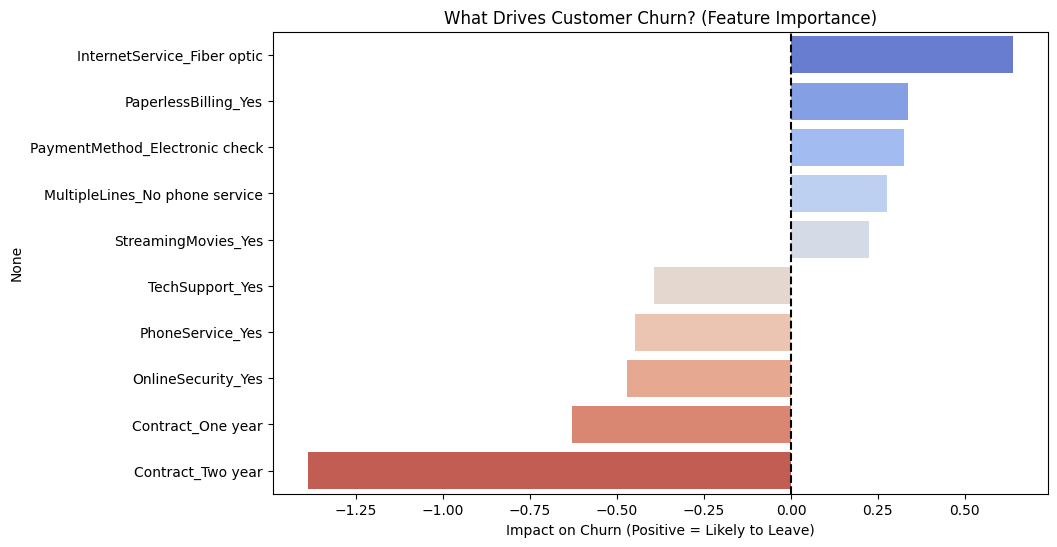

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the "Weights" from the model.
weights = pd.Series(logmodel.coef_[0], index=X.columns)

# 2. Sort them to see the biggest drivers (Positive = Increases Churn, Negative = Reduces Churn).
weights = weights.sort_values(ascending=False)

# 3. Plot the top 5 predictors for Churn.
plt.figure(figsize=(10, 6))

# Taking the top 5 positive (churn drivers) and top 5 negative (retention drivers).
top_weights = pd.concat([weights.head(5), weights.tail(5)])
sns.barplot(x=top_weights.values, y=top_weights.index, palette='coolwarm')
plt.title('What Drives Customer Churn? (Feature Importance)')
plt.xlabel('Impact on Churn (Positive = Likely to Leave)')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

Insights:
Positive Drivers of Customer Churn
1. InternetService_Fibre Optic -Since Fiber is usually the "premium/fastest" service, this implies a quality or price expectation mismatch. Customers are paying more but likely experiencing outages or bad service.
2. PaperlessBilling_Yes/PaymentMethod_Electronic check -This is a Process Friction Issue, electronic checks are manual. If a customer forgets to pay, they get cut off which leads to them getting angry and thereafter churn.

Negative Impact on Customer Churn
1. Contract_Two year -Locking customers in is the single most effective way to keep them.
2. OnlineSecurity_Yes -Customers who buy "add-ons" (like security) are "sticky." They are deeper into the ecosystem.

Business Recommendations & Strategy
Current Status: The analysis reveals a Churn Rate of 26.54%, which is critically high.The predictive model (Accuracy: 82%) identified specific friction points in service quality and billing that are driving customers away.

To reduce churn and protect revenue, I propose the following three-pillar strategy:

1. The "Fiber Optic" Task Force (Quality Assurance)
The Problem: The model identifies Fiber Optic internet as the #1 strongest predictor of churn. Customers on this premium plan are leaving at alarming rates.

The Insight: This suggests a "Value Gap." Customers are paying a premium price but likely experiencing outages, slow speeds, or poor support. They feel they aren't getting what they paid for.

Recommendation: Launch an immediate technical audit of Fiber Optic infrastructure in high-churn regions. Consider offering a temporary "Quality Guarantee" discount to Fiber customers until stability metrics improve.

2. Frictionless Payments (Process Improvement)
The Problem: Customers paying via Electronic Check are significantly more likely to churn than those using credit cards or automated bank transfers.

The Insight: Electronic checks require manual effort from the customer every month. If they forget, they face service interruption, which triggers anger and cancellation.

Recommendation: Incentivize "Auto-Pay." Offer a 2-5% discount or 5GB extra data for customers who switch from Electronic Check to automatic Credit Card payments. This removes the monthly "decision point" where a customer might choose to cancel.

3. The "Lock-In" Strategy (Contract Migration)
The Problem: Month-to-month contracts create a low barrier to exit.

The Insight: The data proves that a Two-Year Contract is the strongest predictor of customer retention.

Recommendation: Aggressively migrate month-to-month users to yearly plans.

Tactic: Launch a "Loyalty Upgrade" campaign. Offer the 13th month free or free Online Security (another strong retention factor) to any month-to-month customer who commits to a 1-year contract.